# Trial Onset ~ all frequencies: LL12

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
from BCI2kReader import BCI2kReader as b2k
import os
import mne
from tabulate import tabulate
import IPython
import seaborn as sns
import scipy
import joblib

import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest

# Import required code for visualizing example models
from fooof import FOOOF
from fooof.sim.gen import gen_power_spectrum
from fooof.sim.utils import set_random_seed
from fooof.plts.spectra import plot_spectra
from fooof.plts.annotate import plot_annotated_model
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series
from neurodsp.spectral import compute_spectrum, rotate_powerlaw
from neurodsp.plts.spectral import plot_power_spectra



In [2]:
## Prep paths ##

subject = 'LL12'
raw_data_dir = f"/home/brooke/pacman/raw_data/{subject}"
preproc_data_dir = f"/home/brooke/pacman/preprocessing/{subject}/ieeg"

In [3]:
## Load Neural Data

# load
trial_onset_epochs = mne.read_epochs(f"{preproc_data_dir}/{subject}_bp_clean_pres-locked_ieeg.fif")

# get good epochs (for behavioral data only)
good_epochs = [i for i,x in enumerate(trial_onset_epochs.get_annotations_per_epoch()) if not x]
bad_epochs = [i for i,x in enumerate(trial_onset_epochs.get_annotations_per_epoch()) if  x]

# onlt good epochs
trial_onset_epochs = trial_onset_epochs[good_epochs]

Reading /home/brooke/pacman/preprocessing/LL12/ieeg/LL12_bp_clean_pres-locked_ieeg.fif ...
    Found the data of interest:
        t =   -4000.00 ...    9000.00 ms
        0 CTF compensation matrices available


/tmp/ipykernel_468192/973766942.py:4: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/LL12/ieeg/LL12_bp_clean_pres-locked_ieeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  trial_onset_epochs = mne.read_epochs(f"{preproc_data_dir}/{subject}_bp_clean_pres-locked_ieeg.fif")


0 bad epochs dropped
Not setting metadata
260 matching events found
No baseline correction applied
0 projection items activated


In [4]:
## Dictionary of electrode locations ##

# Dictionary mapping ROI to elecs
ROIs = {
    'hc'     :['LH1', 'LH2', 'LHP1', 'LHP2', 'RH1'],
    'ofc'    :['ROF1'],
    'amyg'   :['LA1', 'LA2', 'LA3'],
    'cing'   :['LAC1'],
    'insula' :['LAI2', 'LAI3', ],
    'dlpfc'  :['LAC6', 'LAC7', 'LAC8', 'LMC7', 'LMC8'],
    'ec'     :[]
}

## prep lists

# primary ROI
hc_list = []
hc_indices = []
hc_names = []
ofc_list = []
ofc_indices = []
ofc_names = []
amyg_list = []
amyg_names = [] 
amyg_indices = []
cing_list = []
cing_names = [] 
cing_indices = []

# control ROI
insula_list = []
insula_names = []  
insula_indices = []
dlpfc_list = []
dlpfc_names = []  
dlpfc_indices = []
ec_list = []
ec_names = []  
ec_indices = []

# exclude bad ROI from list
pairs_long_name = [ch.split('-') for ch in trial_onset_epochs.info['ch_names']]
bidx = len(trial_onset_epochs.info['bads']) +1
pairs_name = pairs_long_name[bidx:len(pairs_long_name)]

# sort ROI into lists
for ix in range(0, len(pairs_name)):
    if pairs_name[ix][0] in ROIs['hc'] or pairs_name[ix][1] in ROIs['hc']:
        hc_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])
        hc_names.append(pairs_name[ix])
        hc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['ofc'] or pairs_name[ix][1] in ROIs['ofc']:
        ofc_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])
        ofc_names.append(pairs_name[ix])
        ofc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['amyg'] or pairs_name[ix][1] in ROIs['amyg']:
        amyg_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])       
        amyg_names.append(pairs_name[ix])
        amyg_indices.append(ix)
    if pairs_name[ix][0] in ROIs['cing'] or pairs_name[ix][1] in ROIs['cing']:
        cing_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])       
        cing_names.append(pairs_name[ix])
        cing_indices.append(ix)
        
    # control roi
    if pairs_name[ix][0] in ROIs['insula'] or pairs_name[ix][1] in ROIs['insula']:
        insula_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])       
        insula_names.append(pairs_name[ix])
        insula_indices.append(ix)
    if pairs_name[ix][0] in ROIs['dlpfc'] or pairs_name[ix][1] in ROIs['dlpfc']:
        dlpfc_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])       
        dlpfc_names.append(pairs_name[ix])
        dlpfc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['ec'] or pairs_name[ix][1] in ROIs['ec']:
        ec_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])       
        ec_names.append(pairs_name[ix])
        ec_indices.append(ix)        
        

In [5]:
## funcions

def MM_compute_TFR(epochs, freqs, n_cycles, baseline, zscore=True, workers = 8):
    """ function to compute TFR via Morlet wavelets
    
    epochs:                     MNE epoch object with channels of interest
    freqs:                      list of frequencies, should be log spaced
    n_cycles:                   number of cycles, adjust with freqs to balance temporal and frequency resolution
    baseline:                   tuple that specifies the time in seconds that baseline should be calculated on 
                                (should be 1-2s smaller than epoch TFR was calculated on to exclude artificats on morlet waves
    zscore:                     boolean, if True zscores within trial and frequency band across the time window specified in baseline
    workers:                    number of threads to use while calculating TFR
    """
    print('computing TFR')
    TFR = mne.time_frequency.tfr_morlet(epochs,freqs,n_cycles,return_itc=False,
                                            average=False,  n_jobs = workers)
    print('log transforming')
    TFR.data = np.log(TFR.data)
    if zscore:
        print('z-scoring to baseline')
        bix = [a and b  for a, b in zip(TFR.times >= baseline[0], TFR.times <= baseline[1])]
        bmean = TFR.data[:,:,:,bix].mean(axis=(3),keepdims=True)
        bstd = TFR.data[:,:,:,bix].std(axis=(3),keepdims=True)
        TFR.data = (TFR.data - bmean) / bstd
    return TFR

def extract_freqs(lower_freq, higher_freq, freq_band, subdir, ROI, label, TFR, trials):
    """ function to extract and average the across the freqs within a given band and save out to csvs
    step is calculated based on getting ~4 samples per frequency cycle
    
    lower_freq, higher_freq:    non inclusive lower and upper bounds of the band
    freq_band:                  band name, as a string
    subdir:                     dir in sub/ieeg/ that specifies the time locking
    ROI:                        region name, as a string
    label:                      label, eg ghost, no ghost, choice locked etc, as a string
    TFR:                        MNE TFR object
    """
    
    # calculate step, ## note I made this up, but it seems reasonable?
    step = {
        'delta'      : int(np.floor(TFR.info['sfreq']/(2*4))),
        'theta'      : int(np.floor(TFR.info['sfreq']/(5*4))),
        'alpha'      : int(np.floor(TFR.info['sfreq']/(11*4))),
        'beta'       : int(np.floor(TFR.info['sfreq']/(22*4))),
        'gamma'      : int(np.floor(TFR.info['sfreq']/(50*4))),
        'hfa'        : int(np.floor(TFR.info['sfreq']/(110*4)))
    }
    
    # check if it needs to be calculated with subbands
    if freq_band == 'gamma' or freq_band == 'hfa':
        
        if TFR.info['sfreq'] < 1000:
                                raise Exception('Sampling Rate is below 1000, should calculate gamma or HFA') 
        
        subband_dict = {
            'gamma'    : [(30, 40), (35, 45), (40, 50), (45, 55), (50, 60), (55, 65), (60, 70)],
            'hfa'      : [(70, 90), (80, 100), (90, 110), (100, 120), (110, 130), (120, 140), (130, 150)]
        }
        
        for chix in range(len(TFR.ch_names)):
            subb_trial_power = []
            for subb in subband_dict[freq_band]:
                fidx = np.where((freqs > subb[0]) & (freqs < subb[1]))[0]
                subb_trial_power.append(TFR.data[:, chix, fidx, :].mean(axis=1))
            trial_power = np.mean(subb_trial_power, axis = 0)
            channel_df = pd.DataFrame(trial_power[:, ::step[freq_band]])
            channel_df["trial"] = trials
            channel_df.to_csv(f"{preproc_data_dir}/{subdir}/{TFR.ch_names[chix]}_{ROI}_trial_{freq_band}_{label}.csv")
    
    else:
        fidx = np.where((freqs > lower_freq) & (freqs < higher_freq))[0]
        for chix in range(len(TFR.ch_names)):
            trial_power = TFR.data[:, chix, fidx, :].mean(axis=1)
            channel_df = pd.DataFrame(trial_power[:, ::step[freq_band]])
            channel_df["trial"] = trials
            channel_df.to_csv(f"{preproc_data_dir}/{subdir}/{TFR.ch_names[chix]}_{ROI}_trial_{freq_band}_{label}.csv")

In [6]:
# Set frequencies

freqs = np.logspace(start = np.log10(1), stop = np.log10(150), num = 80, base = 10, endpoint = True)
n_cycles = np.logspace(np.log10(2), np.log10(30), base = 10, num = 80)

# formulas to check bandwidth and time bin
band_width = (freqs / n_cycles) * 2
time_bin = n_cycles / freqs / np.pi
print(freqs)
print(n_cycles)
print(time_bin)
print(band_width)


[  1.           1.06548039   1.13524845   1.20958496   1.28878905
   1.37317945   1.46309577   1.55889984   1.6609772    1.76973863
   1.8856218    2.00909304   2.14064922   2.28081976   2.43016872
   2.5892971    2.75884527   2.93949552   3.13197482   3.33705774
   3.55556956   3.78838962   4.03645484   4.30076345   4.5823791
   4.88243505   5.20213877   5.54277682   5.90571998   6.2924288
   6.70445946   7.14347005   7.61122722   8.10961331   8.64063391
   9.20642595   9.80926626  10.45158079  11.13595433  11.8651409
  12.6420749   13.46988283  14.35189595  15.29166362  16.29296764
  17.35983743  18.49656627  19.70772855  20.99819821  22.37316831
  23.83817199  25.39910467  27.06224782  28.83429423  30.72237491
  32.73408785  34.87752853  37.16132253  39.59466023  42.18733383
  44.94977669  47.89310538  51.02916436  54.37057369  57.93077979
  61.72410955  65.76582801  70.07219975  74.66055437  79.54935622
  84.75827869  90.30828341  96.22170458 102.52233885 109.23554107
 116.38832636

# Main Regions of Interest

## Hippocampus

In [7]:
hc_list

['LH2-LH3', 'RH1-RH2']

In [8]:
# only ROI of interest
trial_onset_roi = trial_onset_epochs.copy().pick_channels(hc_list)


In [9]:
# Resample to 1000
if trial_onset_roi.info['sfreq'] > 1000:
    trial_onset_roi= trial_onset_roi.resample(1000)


In [11]:
# compute TRF

roi_pres_TFR = []
roi_pres_TFR = MM_compute_TFR(trial_onset_roi,freqs,n_cycles,baseline = (-1,5), zscore=True)


computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   18.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   18.5s finished


Not setting metadata
log transforming
z-scoring to baseline


In [12]:
roi_pres_TFR.crop(tmin = -1, tmax = 5)

<EpochsTFR | time : [-1.000000, 5.000000], freq : [1.000000, 150.000000], epochs : 187, channels : 2, ~701.5 MB>

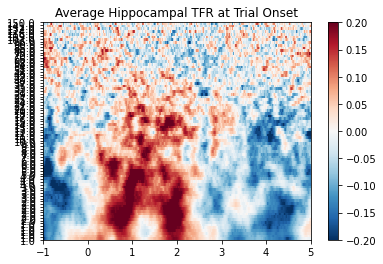

In [13]:
plt.rcParams['figure.figsize'] = [14, 11]


fig, ax = plt.subplots()
i = ax.imshow(roi_pres_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]], vmin = -.2, vmax = .2)
ax.set_yticks(np.linspace(np.min(roi_pres_TFR.freqs),np.max(roi_pres_TFR.freqs),len(roi_pres_TFR.freqs)))
ax.set_yticklabels(np.round(roi_pres_TFR.freqs))
bar = plt.colorbar(i)
ax.set_title("Average Hippocampal TFR at Trial Onset")
fig.savefig(f'figures/{subject}_average_hc_trialonset.png', dpi=600)
fig.show()


## Individual Channels

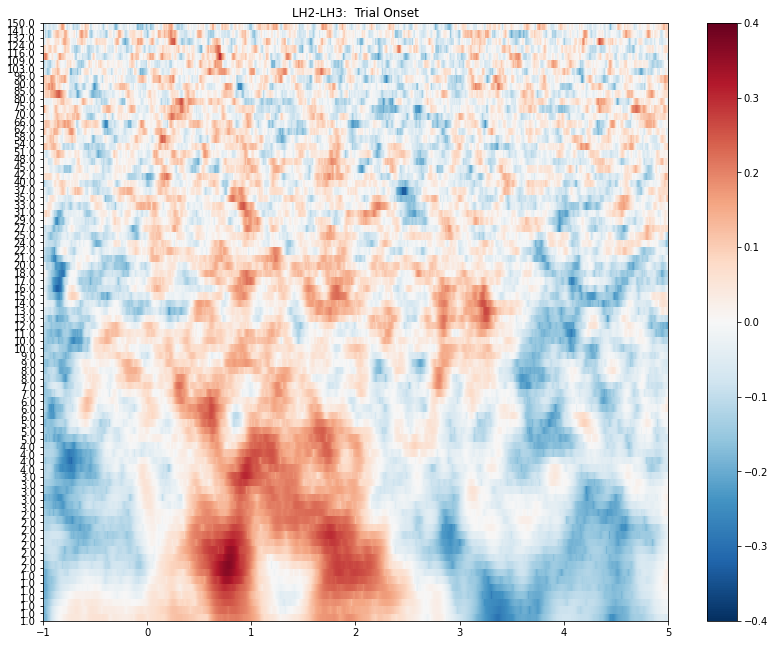

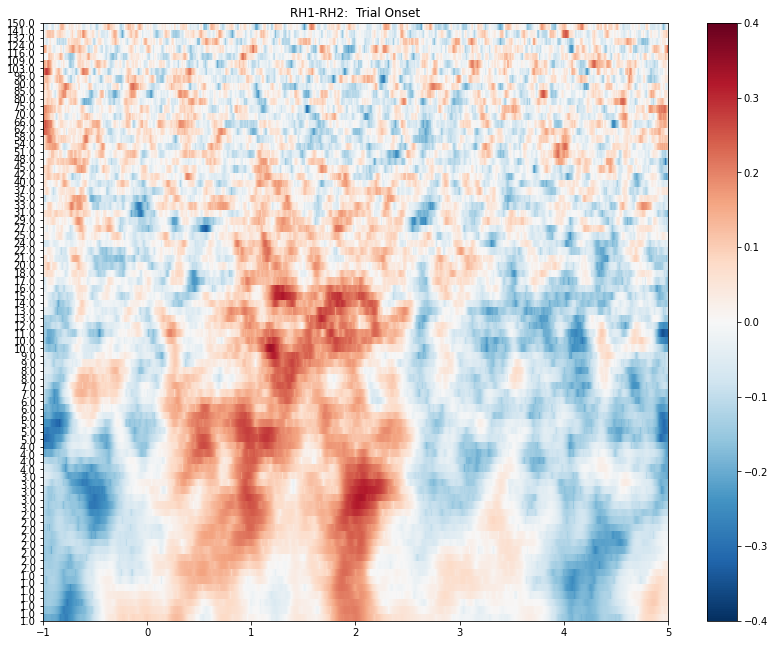

In [14]:
plt.rcParams['figure.figsize'] = [14, 11]

chix = 0
for ch in roi_pres_TFR.ch_names:

    fig, ax = plt.subplots()
    i = ax.imshow(roi_pres_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
    ax.set_yticks(np.linspace(np.min(roi_pres_TFR.freqs),np.max(roi_pres_TFR.freqs),len(roi_pres_TFR.freqs)))
    ax.set_yticklabels(np.round(roi_pres_TFR.freqs))
    bar = plt.colorbar(i)
    ax.set_title(f"{ch}:  Trial Onset")
    fig.show()

    
    chix = chix + 1

## Export freq data locked to turn around time to csvs

In [15]:
# delta
extract_freqs(1, 3, "delta", "trial_onset", "hc", "onset_locked_ghost", roi_pres_TFR, good_epochs)
# theta
extract_freqs(3, 8, "theta", "trial_onset", "hc", "onset_locked_ghost", roi_pres_TFR, good_epochs)
# alpha
extract_freqs(8, 13, "alpha", "trial_onset", "hc", "onset_locked_ghost", roi_pres_TFR, good_epochs)
# beta
extract_freqs(13, 30, "beta", "trial_onset", "hc", "onset_locked_ghost", roi_pres_TFR, good_epochs)
# # gamma
# extract_freqs(30, 70, "gamma", "trial_onset", "hc", "onset_locked_ghost", roi_pres_TFR, good_epochs)
# # HFA
# extract_freqs(70, 150, "hfa", "trial_onset", "hc", "onset_locked_ghost", roi_pres_TFR, good_epochs)


# OFC

In [16]:
ofc_list

['ROF1-ROF2']

In [18]:
# only roi of interest
trial_onset_roi = trial_onset_epochs.copy().pick_channels(ofc_list)


In [19]:
# Resample to 1000
if trial_onset_roi.info['sfreq'] > 1000:
    trial_onset_roi= trial_onset_roi.resample(1000)


In [20]:
# compute TFR

roi_pres_TFR = []

roi_pres_TFR = MM_compute_TFR(trial_onset_roi,freqs,n_cycles,baseline = (-1,5), zscore=True)


computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Not setting metadata


[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:   16.4s finished


log transforming
z-scoring to baseline


In [21]:
roi_pres_TFR.crop(tmin = -1, tmax = 5)


<EpochsTFR | time : [-1.000000, 5.000000], freq : [1.000000, 150.000000], epochs : 187, channels : 1, ~350.7 MB>

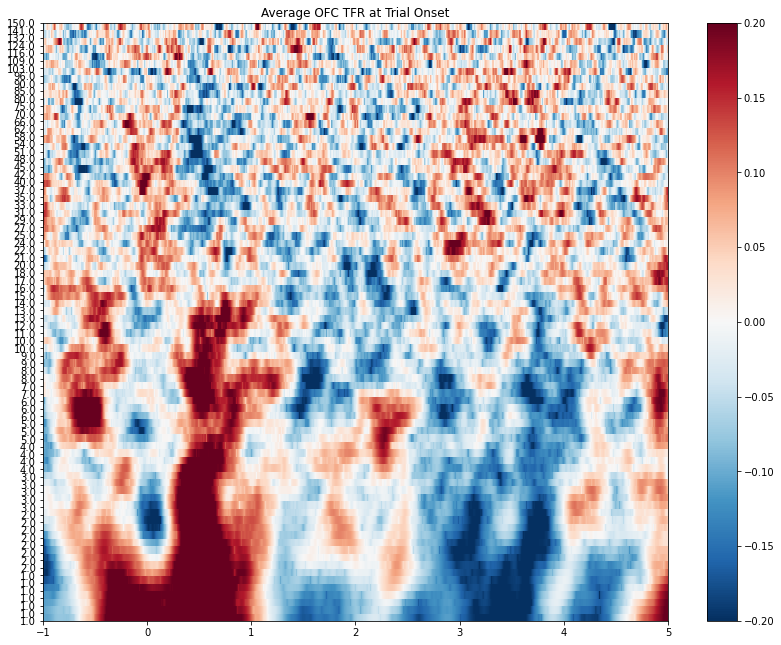

In [22]:
plt.rcParams['figure.figsize'] = [14, 11]

fig, ax = plt.subplots()
i = ax.imshow(roi_pres_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]], vmin = -.2, vmax = .2)
ax.set_yticks(np.linspace(np.min(roi_pres_TFR.freqs),np.max(roi_pres_TFR.freqs),len(roi_pres_TFR.freqs)))
ax.set_yticklabels(np.round(roi_pres_TFR.freqs))
bar = plt.colorbar(i)
ax.set_title("Average OFC TFR at Trial Onset")
fig.savefig(f'figures/{subject}_average_ofc_trialonset.png', dpi=600)
fig.show()


### Individual Channels

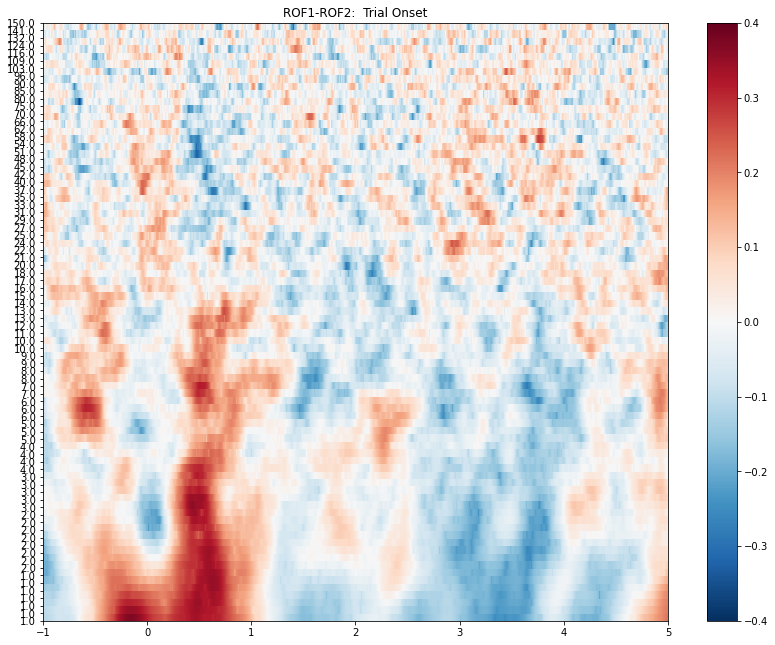

In [23]:
plt.rcParams['figure.figsize'] = [14, 11]

chix = 0
for ch in roi_pres_TFR.ch_names:

    fig, ax = plt.subplots()
    i = ax.imshow(roi_pres_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
    ax.set_yticks(np.linspace(np.min(roi_pres_TFR.freqs),np.max(roi_pres_TFR.freqs),len(roi_pres_TFR.freqs)))
    ax.set_yticklabels(np.round(roi_pres_TFR.freqs))
    bar = plt.colorbar(i)
    ax.set_title(f"{ch}:  Trial Onset")
    fig.show()
    
    chix = chix + 1

### Export freq data locked to turn around time to csvs

In [24]:
# delta
extract_freqs(1, 3, "delta", "trial_onset", "ofc", "onset_locked_ghost", roi_pres_TFR, good_epochs)
# theta
extract_freqs(3, 8, "theta", "trial_onset", "ofc", "onset_locked_ghost", roi_pres_TFR, good_epochs)
# alpha
extract_freqs(8, 13, "alpha", "trial_onset", "ofc", "onset_locked_ghost", roi_pres_TFR, good_epochs)
# beta
extract_freqs(13, 30, "beta", "trial_onset", "ofc", "onset_locked_ghost", roi_pres_TFR, good_epochs)
# # gamma
# extract_freqs(30, 70, "gamma", "trial_onset", "ofc", "onset_locked_ghost", roi_pres_TFR, good_epochs)
# # HFA
# extract_freqs(70, 150, "hfa", "trial_onset", "ofc", "onset_locked_ghost", roi_pres_TFR, good_epochs)


# Amygdala

In [25]:
amyg_list

['LA1-LA2', 'LA2-LA3', 'LA3-LA4']

In [26]:
# only roi 
trial_onset_roi = trial_onset_epochs.copy().pick_channels(amyg_list)


In [27]:
# Resample to 1000
if trial_onset_roi.info['sfreq'] > 1000:
    trial_onset_roi= trial_onset_roi.resample(1000)

In [28]:
# compute TFR
roi_pres_TFR = []

roi_pres_TFR = MM_compute_TFR(trial_onset_roi,freqs,n_cycles,baseline = (-1,5), zscore=True)


computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:   19.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:   19.6s finished


Not setting metadata
log transforming
z-scoring to baseline


In [29]:
roi_pres_TFR.crop(tmin = -1, tmax = 5)


<EpochsTFR | time : [-1.000000, 5.000000], freq : [1.000000, 150.000000], epochs : 187, channels : 3, ~1.03 GB>

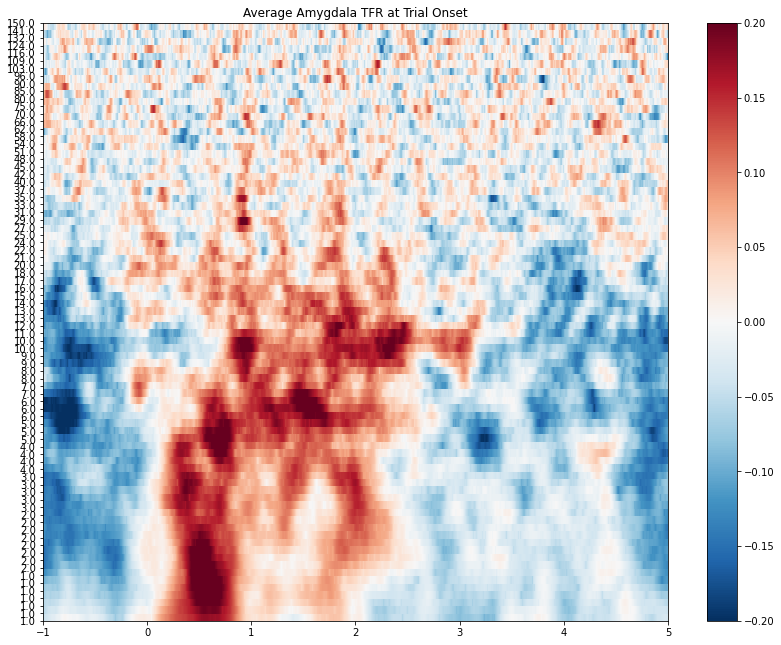

In [30]:
plt.rcParams['figure.figsize'] = [14, 11]

fig, ax = plt.subplots()
i = ax.imshow(roi_pres_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]], vmin =-.2, vmax = .2)
ax.set_yticks(np.linspace(np.min(roi_pres_TFR.freqs),np.max(roi_pres_TFR.freqs),len(roi_pres_TFR.freqs)))
ax.set_yticklabels(np.round(roi_pres_TFR.freqs))
bar = plt.colorbar(i)
ax.set_title("Average Amygdala TFR at Trial Onset")
fig.savefig(f'figures/{subject}_average_amyg_trialonset.png', dpi=600)
fig.show()


### Individual Channels

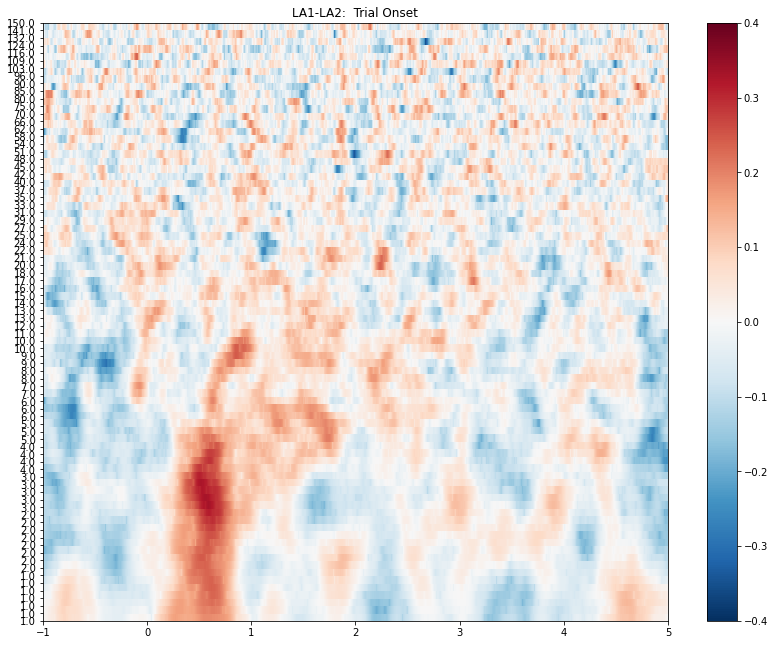

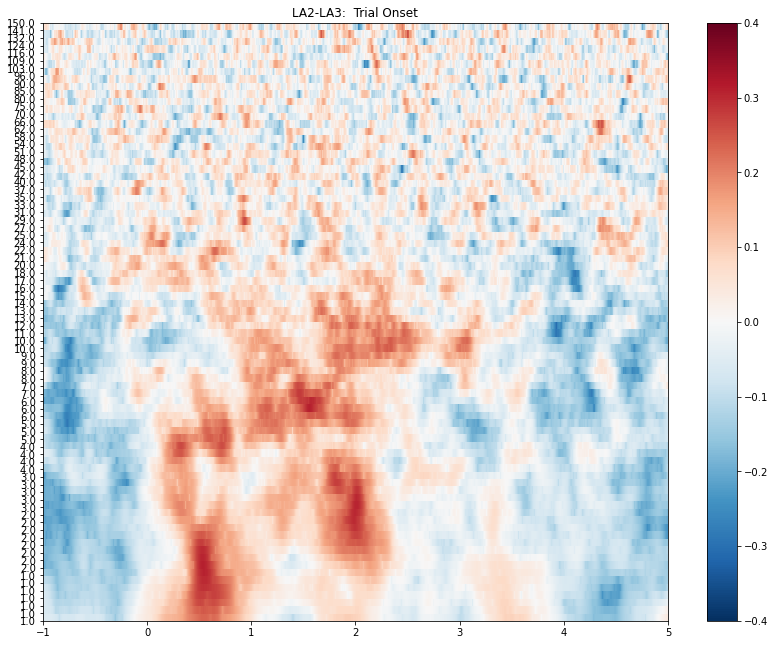

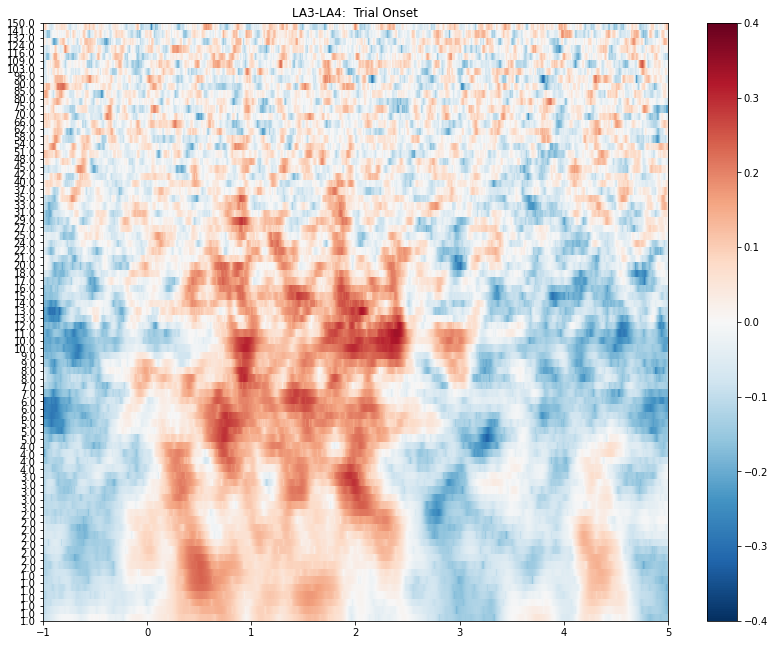

In [31]:
plt.rcParams['figure.figsize'] = [14, 11]

chix = 0
for ch in roi_pres_TFR.ch_names:

    fig, ax = plt.subplots()
    i = ax.imshow(roi_pres_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
    ax.set_yticks(np.linspace(np.min(roi_pres_TFR.freqs),np.max(roi_pres_TFR.freqs),len(roi_pres_TFR.freqs)))
    ax.set_yticklabels(np.round(roi_pres_TFR.freqs))
    bar = plt.colorbar(i)
    ax.set_title(f"{ch}:  Trial Onset")
    fig.show()
    
    chix = chix + 1

### Export freq data locked to turn around time to csvs

In [32]:
# delta
extract_freqs(1, 3, "delta", "trial_onset", "amyg", "onset_locked_ghost", roi_pres_TFR, good_epochs)
# theta
extract_freqs(3, 8, "theta", "trial_onset", "amyg", "onset_locked_ghost", roi_pres_TFR, good_epochs)
# alpha
extract_freqs(8, 13, "alpha", "trial_onset", "amyg", "onset_locked_ghost", roi_pres_TFR, good_epochs)
# beta
extract_freqs(13, 30, "beta", "trial_onset", "amyg", "onset_locked_ghost", roi_pres_TFR, good_epochs)
# # gamma
# extract_freqs(30, 70, "gamma", "trial_onset", "amyg", "onset_locked_ghost", roi_pres_TFR, good_epochs)
# # HFA
# extract_freqs(70, 150, "hfa", "trial_onset", "amyg", "onset_locked_ghost", roi_pres_TFR, good_epochs)

## Cingulate

In [33]:
cing_list

['LAC1-LAC2']

In [34]:
# only roi 
trial_onset_roi = trial_onset_epochs.copy().pick_channels(cing_list)


In [35]:
# Resample to 1000
if trial_onset_roi.info['sfreq'] > 1000:
    trial_onset_roi= trial_onset_roi.resample(1000)

In [36]:
# Compute TFR

roi_pres_TFR = []

roi_pres_TFR = MM_compute_TFR(trial_onset_roi,freqs,n_cycles,baseline = (-1,5), zscore=True)


computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Not setting metadata


[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:   17.2s finished


log transforming
z-scoring to baseline


In [37]:
roi_pres_TFR.crop(tmin = -1, tmax = 5)


<EpochsTFR | time : [-1.000000, 5.000000], freq : [1.000000, 150.000000], epochs : 187, channels : 1, ~350.7 MB>

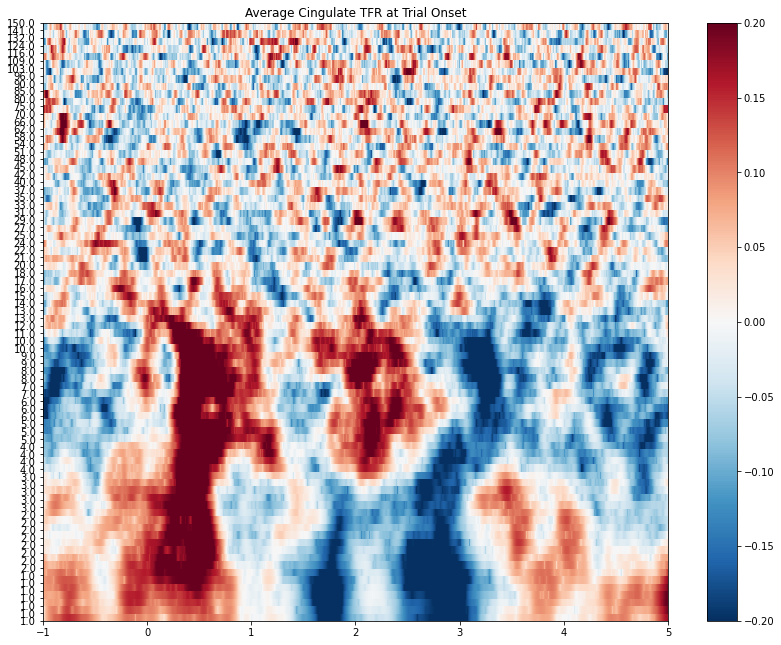

In [38]:
plt.rcParams['figure.figsize'] = [14, 11]

fig, ax = plt.subplots()
i = ax.imshow(roi_pres_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]], vmin =-.2, vmax = .2)
ax.set_yticks(np.linspace(np.min(roi_pres_TFR.freqs),np.max(roi_pres_TFR.freqs),len(roi_pres_TFR.freqs)))
ax.set_yticklabels(np.round(roi_pres_TFR.freqs))
bar = plt.colorbar(i)
ax.set_title("Average Cingulate TFR at Trial Onset")
fig.savefig(f'figures/{subject}_average_cing_trialonset.png', dpi=600)
fig.show()


### Individual Channels

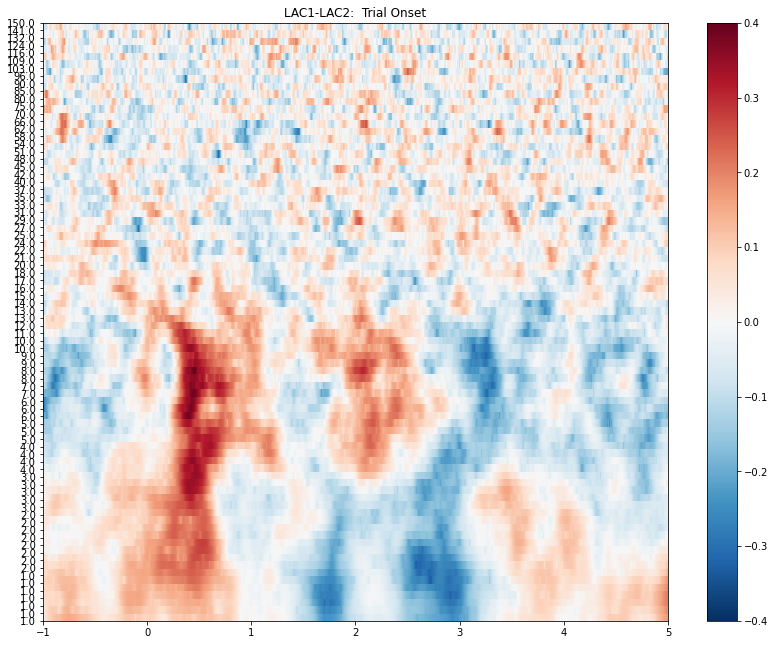

In [39]:
plt.rcParams['figure.figsize'] = [14, 11]

chix = 0
for ch in roi_pres_TFR.ch_names:

    fig, ax = plt.subplots()
    i = ax.imshow(roi_pres_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
    ax.set_yticks(np.linspace(np.min(roi_pres_TFR.freqs),np.max(roi_pres_TFR.freqs),len(roi_pres_TFR.freqs)))
    ax.set_yticklabels(np.round(roi_pres_TFR.freqs))
    bar = plt.colorbar(i)
    ax.set_title(f"{ch}:  Trial Onset")
    fig.show()

    chix = chix + 1

### Export freq data locked to turn around time to csvs

In [40]:
# delta
extract_freqs(1, 3, "delta", "trial_onset", "cing", "onset_locked_ghost", roi_pres_TFR, good_epochs)
# theta
extract_freqs(3, 8, "theta", "trial_onset", "cing", "onset_locked_ghost", roi_pres_TFR, good_epochs)
# alpha
extract_freqs(8, 13, "alpha", "trial_onset", "cing", "onset_locked_ghost", roi_pres_TFR, good_epochs)
# beta
extract_freqs(13, 30, "beta", "trial_onset", "cing", "onset_locked_ghost", roi_pres_TFR, good_epochs)
# # gamma
# extract_freqs(30, 70, "gamma", "trial_onset", "cing", "onset_locked_ghost", roi_pres_TFR, good_epochs)
# # HFA
# extract_freqs(70, 150, "hfa", "trial_onset", "cing", "onset_locked_ghost", roi_pres_TFR, good_epochs)

# Control Regions

## Insula

In [41]:
insula_list

['LAI1-LAI2', 'LAI2-LAI3', 'LAI3-LAI4']

In [42]:
# Only ROI
trial_onset_roi = trial_onset_epochs.copy().pick_channels(insula_list)


In [43]:
# Resample to 1000
if trial_onset_roi.info['sfreq'] > 1000:
    trial_onset_roi= trial_onset_roi.resample(1000)

In [44]:
# Compute TFR
roi_pres_TFR = []

roi_pres_TFR = MM_compute_TFR(trial_onset_roi,freqs,n_cycles,baseline = (-1,5), zscore=True)


computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:   19.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:   19.9s finished


Not setting metadata
log transforming
z-scoring to baseline


In [45]:
roi_pres_TFR.crop(tmin = -1, tmax = 5)


<EpochsTFR | time : [-1.000000, 5.000000], freq : [1.000000, 150.000000], epochs : 187, channels : 3, ~1.03 GB>

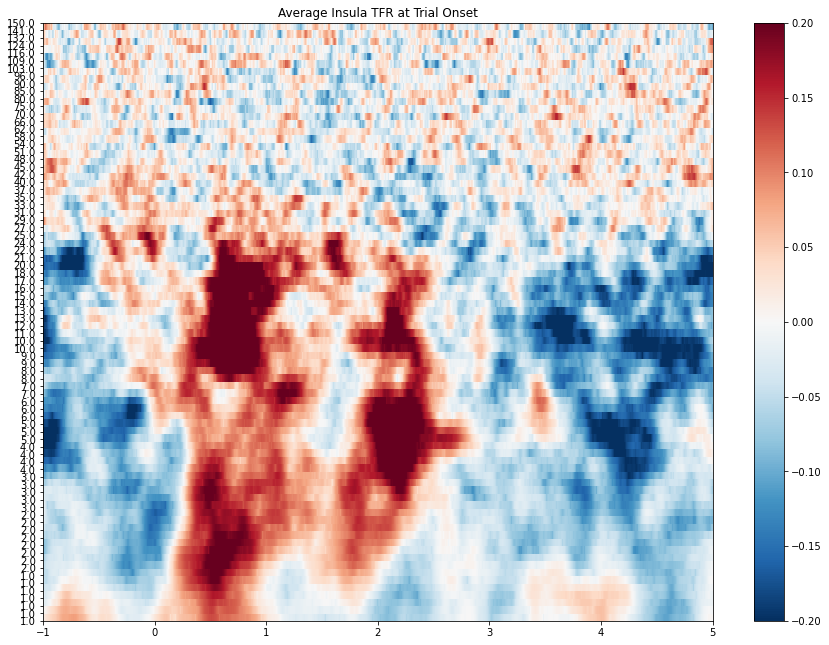

In [46]:
plt.rcParams['figure.figsize'] = [15, 11]

fig, ax = plt.subplots()
i = ax.imshow(roi_pres_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]], vmin =-.2, vmax = .2)
ax.set_yticks(np.linspace(np.min(roi_pres_TFR.freqs),np.max(roi_pres_TFR.freqs),len(roi_pres_TFR.freqs)))
ax.set_yticklabels(np.round(roi_pres_TFR.freqs))
bar = plt.colorbar(i)
ax.set_title("Average Insula TFR at Trial Onset")
fig.savefig(f'figures/{subject}_average_insula_trialonset.png', dpi=600)
fig.show()


### Individual Channels

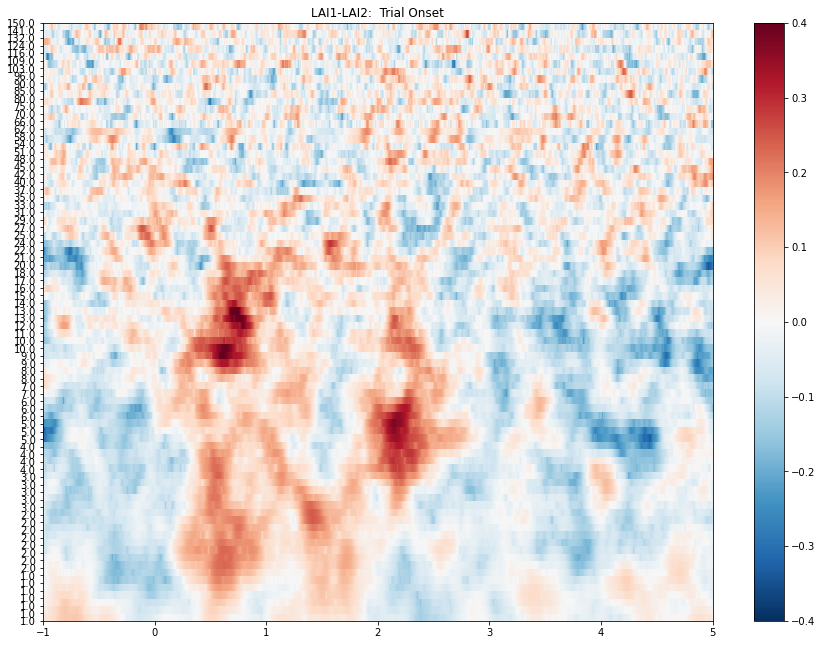

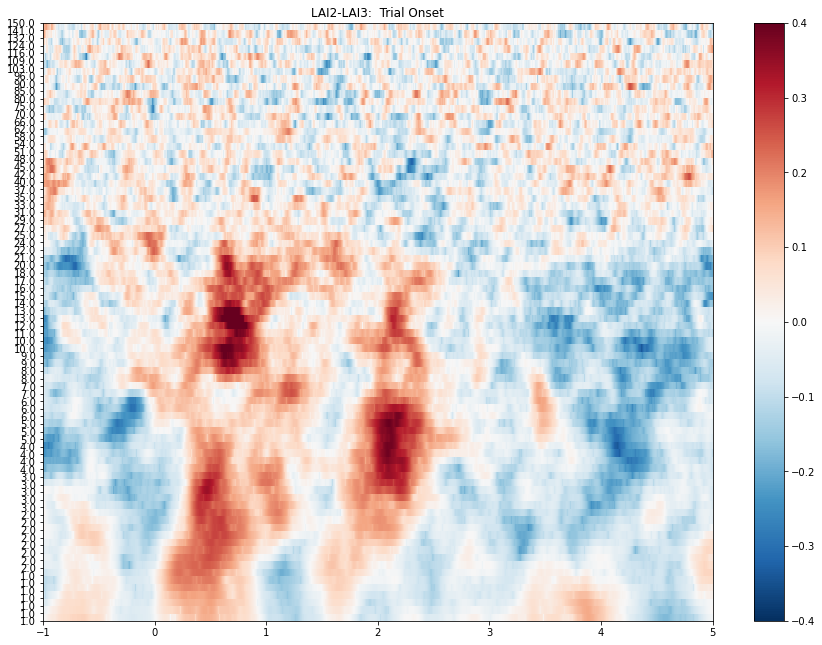

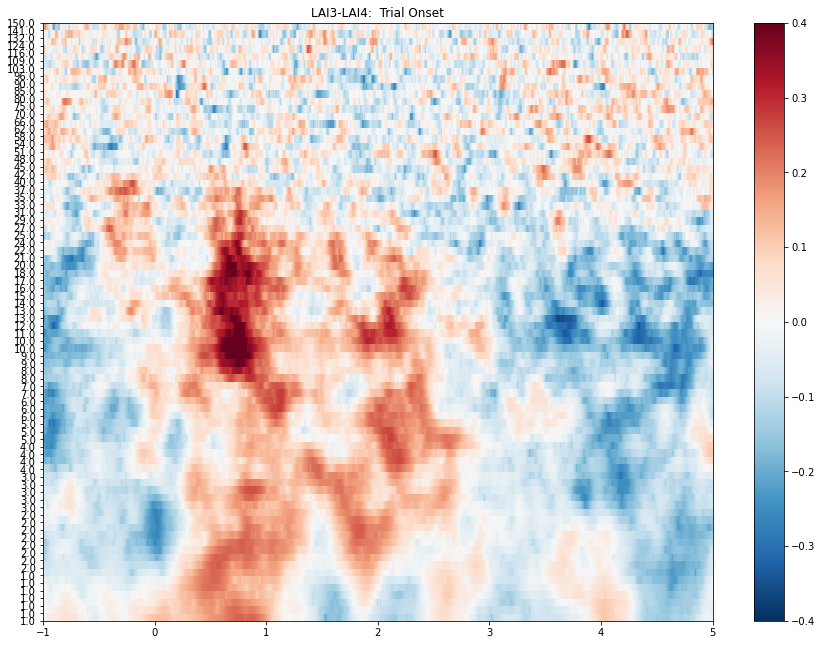

In [47]:
plt.rcParams['figure.figsize'] = [15, 11]

chix = 0
for ch in roi_pres_TFR.ch_names:

    fig, ax = plt.subplots()
    i = ax.imshow(roi_pres_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
    ax.set_yticks(np.linspace(np.min(roi_pres_TFR.freqs),np.max(roi_pres_TFR.freqs),len(roi_pres_TFR.freqs)))
    ax.set_yticklabels(np.round(roi_pres_TFR.freqs))
    bar = plt.colorbar(i)
    ax.set_title(f"{ch}:  Trial Onset")
    fig.show()
   
    chix = chix + 1

### Export freq data locked to turn around time to csvs

In [48]:
# delta
extract_freqs(1, 3, "delta", "trial_onset", "insula", "onset_locked_ghost", roi_pres_TFR, good_epochs)
# theta
extract_freqs(3, 8, "theta", "trial_onset", "insula", "onset_locked_ghost", roi_pres_TFR, good_epochs)
# alpha
extract_freqs(8, 13, "alpha", "trial_onset", "insula", "onset_locked_ghost", roi_pres_TFR, good_epochs)
# beta
extract_freqs(13, 30, "beta", "trial_onset", "insula", "onset_locked_ghost", roi_pres_TFR, good_epochs)
# # gamma
# extract_freqs(30, 70, "gamma", "trial_onset", "insula", "onset_locked_ghost", roi_pres_TFR, good_epochs)
# # HFA
# extract_freqs(70, 150, "hfa", "trial_onset", "insula", "onset_locked_ghost", roi_pres_TFR, good_epochs)

## dlPFC

In [49]:
dlpfc_list

['LAC5-LAC6', 'LAC6-LAC7', 'LAC7-LAC8', 'LMC6-LMC7', 'LMC7-LMC8']

In [50]:
# Only ROI
trial_onset_roi = trial_onset_epochs.copy().pick_channels(dlpfc_list)


In [51]:
# Resample to 1000
if trial_onset_roi.info['sfreq'] > 1000:
    trial_onset_roi= trial_onset_roi.resample(1000)

In [52]:
# Compute TFR
roi_pres_TFR = []

roi_pres_TFR = MM_compute_TFR(trial_onset_roi,freqs,n_cycles,baseline = (-1,5), zscore=True)

computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:   20.3s remaining:   30.4s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:   23.6s finished


Not setting metadata
log transforming
z-scoring to baseline


In [53]:
roi_pres_TFR.crop(tmin = -1, tmax = 5)


<EpochsTFR | time : [-1.000000, 5.000000], freq : [1.000000, 150.000000], epochs : 187, channels : 5, ~1.71 GB>

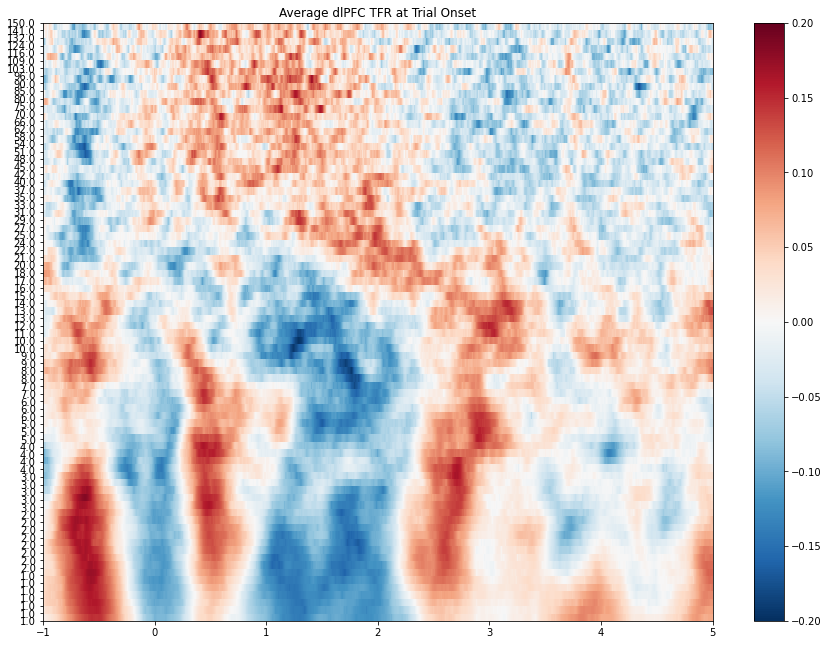

In [54]:
plt.rcParams['figure.figsize'] = [15, 11]

fig, ax = plt.subplots()
i = ax.imshow(roi_pres_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]], vmin =-.2, vmax = .2)
ax.set_yticks(np.linspace(np.min(roi_pres_TFR.freqs),np.max(roi_pres_TFR.freqs),len(roi_pres_TFR.freqs)))
ax.set_yticklabels(np.round(roi_pres_TFR.freqs))
bar = plt.colorbar(i)
ax.set_title("Average dlPFC TFR at Trial Onset")
fig.savefig(f'figures/{subject}_average_dlpfc_trialonset.png', dpi=600)
fig.show()


### Individual Channels

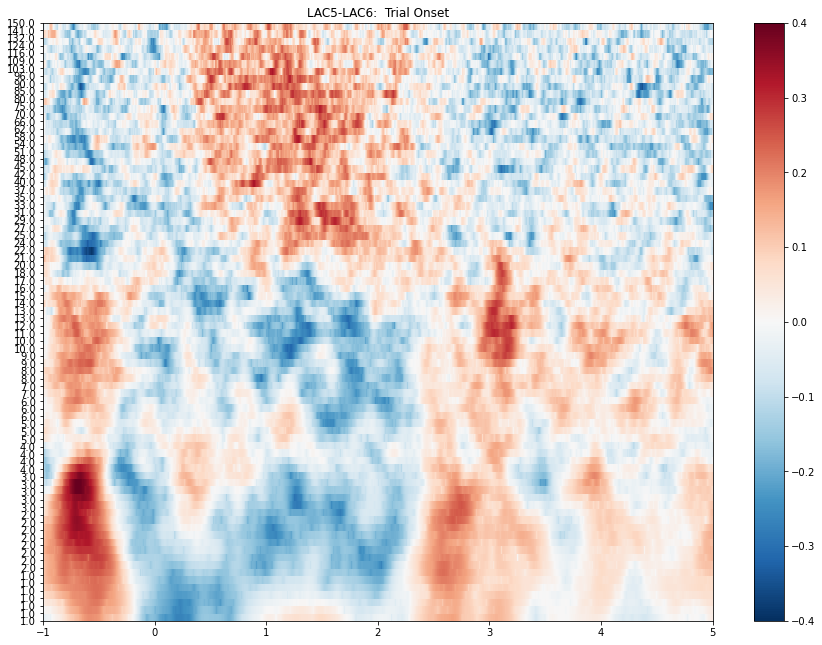

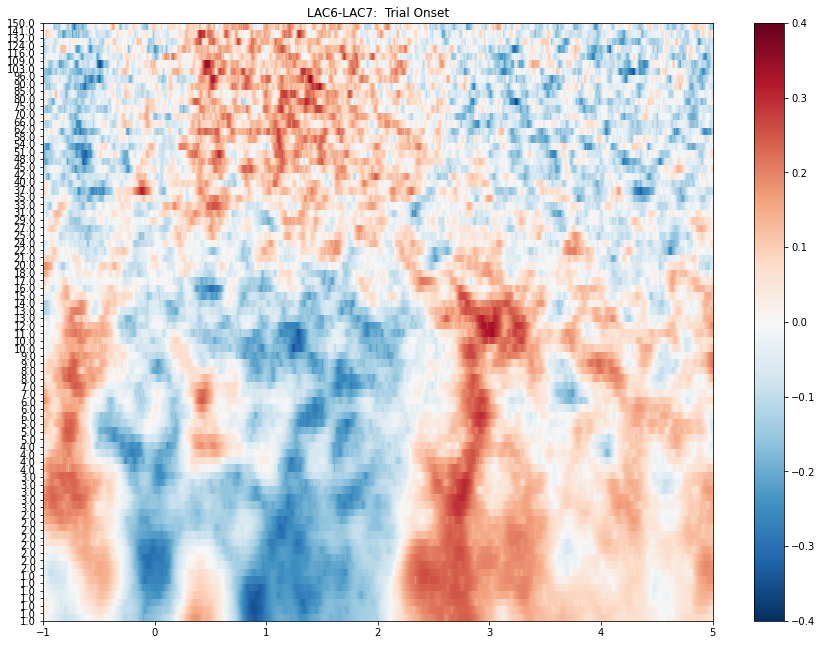

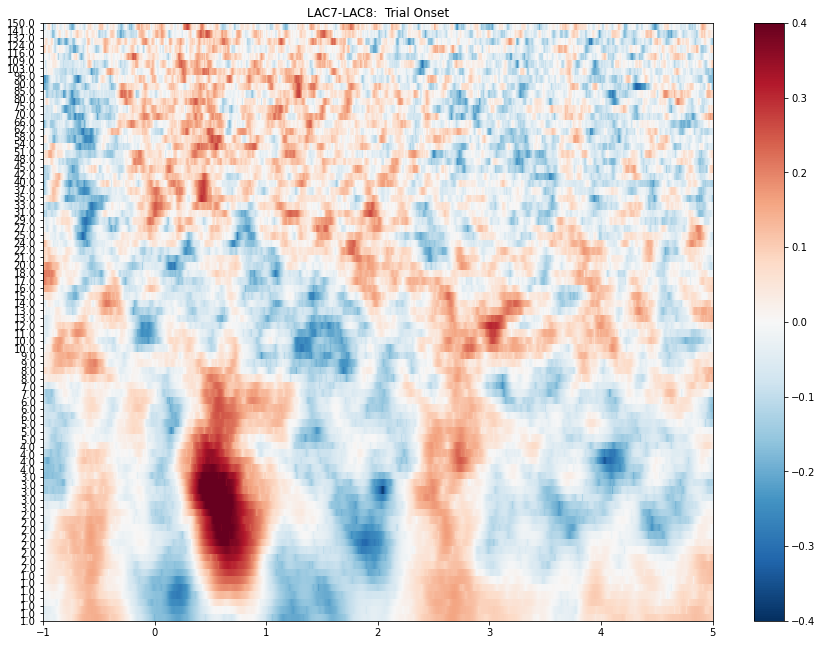

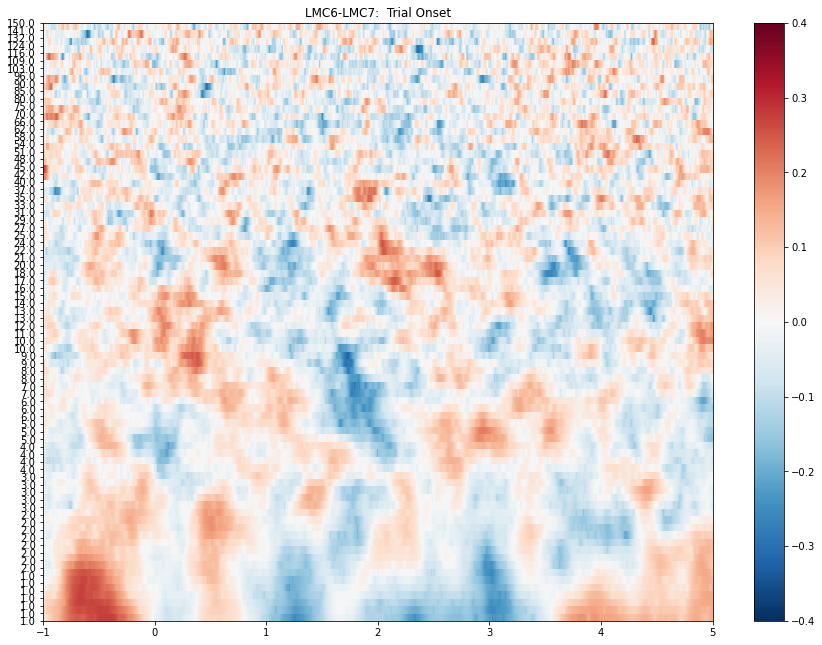

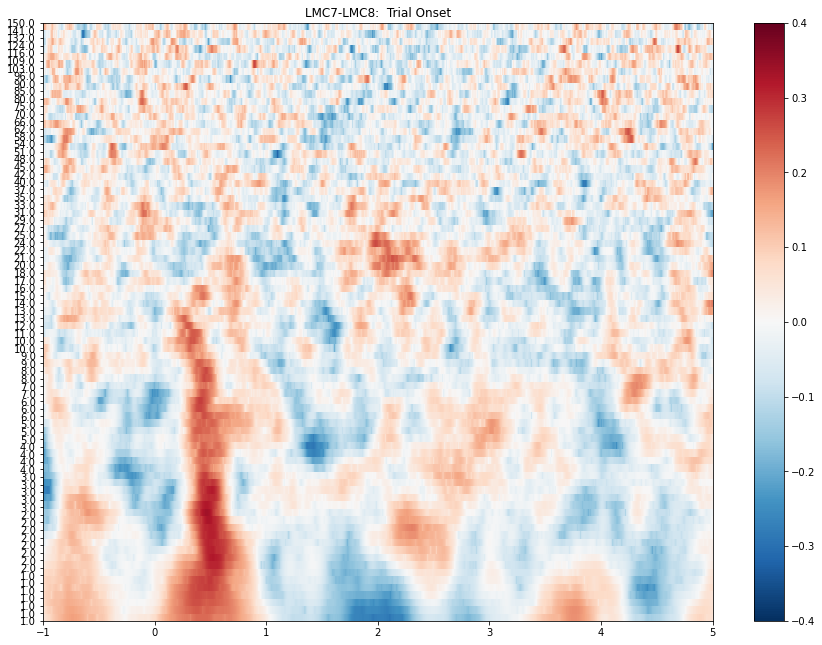

In [55]:
plt.rcParams['figure.figsize'] = [15, 11]

chix = 0
for ch in roi_pres_TFR.ch_names:

    fig, ax = plt.subplots()
    i = ax.imshow(roi_pres_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
    ax.set_yticks(np.linspace(np.min(roi_pres_TFR.freqs),np.max(roi_pres_TFR.freqs),len(roi_pres_TFR.freqs)))
    ax.set_yticklabels(np.round(roi_pres_TFR.freqs))
    bar = plt.colorbar(i)
    ax.set_title(f"{ch}:  Trial Onset")
    fig.show()
    
    chix = chix + 1

### Export freq data locked to turn around time to csvs

In [56]:
# delta
extract_freqs(1, 3, "delta", "trial_onset", "dlpfc", "onset_locked_ghost", roi_pres_TFR, good_epochs)
# theta
extract_freqs(3, 8, "theta", "trial_onset", "dlpfc", "onset_locked_ghost", roi_pres_TFR, good_epochs)
# alpha
extract_freqs(8, 13, "alpha", "trial_onset", "dlpfc", "onset_locked_ghost", roi_pres_TFR, good_epochs)
# beta
extract_freqs(13, 30, "beta", "trial_onset", "dlpfc", "onset_locked_ghost", roi_pres_TFR, good_epochs)
# # gamma
# extract_freqs(30, 70, "gamma", "trial_onset", "dlpfc", "onset_locked_ghost", roi_pres_TFR, good_epochs)
# # HFA
# extract_freqs(70, 150, "hfa", "trial_onset", "dlpfc", "onset_locked_ghost", roi_pres_TFR, good_epochs)